Notebook Logistic Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Logistic Regression toepassen op de data voor classificatie
- andere vormen van classificatie toepassen

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/arifmia/heart-attack-risk-dataset


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- missing data oplossen 
- incorrect types controleren
- numerische waarde standardizeren
- categorische varaiabelen processen
- feature engineering
- select features for modelling
- eenvoudige logistic regression
- eenvoudige logistic regression en unbalance van de features corrigeren met SMOTE- 
- modeling met Logistic Regression, Decision Tree Regression en Random Forrest Regression
- modeling met Hyperparameter tuning met GridSearchCV voor één model Random Forrest


In [2]:
# import van de diverse modules
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# profiling
from summarytools import dfSummary

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from collections import Counter
from sklearn.base import TransformerMixin, BaseEstimator

# Machine learning algorithm
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score


# Mlflow 
import mlflow
import mlflow.sklearn


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# system utils
import warnings
from pathlib import Path
import datetime
from colorama import Fore, Back, Style
import sys
import os
import chardet

from tabulate import tabulate




plot_graphs = True

Extra code snippits die doorheen de notebook gebruikt worden:

save_fig: na generatie van een image kan de image naar file geschreven worden in de images/.. directory. Geef steeds een zinvolle naam

read_JSON: om eenvoudig een JSON in te lezen

log_info:
- logging functie om doorheen de notebooks de status naar file te kunnen schrijven. 
- de logstatements worden tijdens de uitvoering van de code bewaard in een list. Die kan tussentijds naar het scherm geprint worden of naar een file
- log_info_write_to_file: schrijf de loginformatie naar file 
- log_info_print_on_screen: print alle loginfo naar het scherm

In [3]:
# enkele extra code snippets gebruikt doorheen de oefening

# to plot or not to plot - zet op True om de plots te zien, zet op False om de plots niet te zien bij een Run ALL
plot_graphs = True

# schrijf een visual naar file

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Lezen van de JSON-file
def read_JSON(file_path_read):
    with open(file_path_read, 'r') as file:
        files_from_json = json.load(file)
    return files_from_json

# functies om te loggen naar file
log_info_lijst = []

log_filenaam = "LogReg_continue"
if os.path.exists(log_filenaam):
    os.remove(log_filenaam)

def log(log_code="INFO", boodschap="euh geen boodschap????"):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Style.RESET_ALL}{formatted_date} : {log_code} : {boodschap}"
    log_info_lijst.append(log_message)
    with open(log_filenaam, 'a') as file:  # Open the file in append mode
        file.write(boodschap + '\n')  # Voeg een nieuwe regel toe na elke string
    print(log_message)
    return

def log_info(boodschap):
    log("Info",boodschap)
    def log_info_write_to_file(filename):
        with open(filename, 'a') as file:  # Open the file in append mode
            for string in log_info_lijst:
                file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
        return

def log_info_write_to_file(filename):
    with open(filename, 'w') as file:
        for string in log_info_lijst:
            file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
    return

def log_info_print_on_screen():
    for boodschap in log_info_lijst:
        print(boodschap)    
    return

Hulpfuncties

bereken_percentage_outliers: via Isolation forest wordt het percentage van de outliers berekend.
- df : dataframe
- columns_to_use: list van koloms die gebruikt worden om de outliers te berekenen
- functie geeft een percentage terug van het aaantal outliers op het totaal aantal observaties


cap_values: vervang outliers door hun lower of upperpercentieel waarde: de whiskers worden berekend door van de lower_percentieel waarde een waarde af te trekken gelijk aan 1,5 * IQR (interquartile range), voor upper_percentieel waarde wordt de 1,5 * IQR bijgeteld
- df: dataframe
- columns_to_use
- lower_percentieel (default = 25)
- upper_percentieel (default = 75)


In [4]:
# functie om het percentage outliers te berkenen voor een set van kolommen in een dataframe
def bereken_percentage_aantal_outliers(df , columns_to_use):
    # Initialiseren van het Isolation Forest model
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

    # Fit het model
    iso_forest.fit(df[columns_to_use])
    # Voorspellingen
    # Het geeft -1 voor outliers en 1 voor inliers
    labels = iso_forest.predict(df[columns_to_use])
    # Toevoegen van de labels aan het DataFrame om outliers te identificeren
    df_intern = df.copy()
    df_intern['outlier'] = labels
    outliers = df_intern[df_intern['outlier'] == -1]
    aantal_outliers = df_intern['outlier'].value_counts()
    print(aantal_outliers)
    percentage_aantal_outliers = (len(outliers) / len(df_intern)) * 100

    return percentage_aantal_outliers


# functie om outliers in een kolom te cappen op een percentiel waarde
def cap_values(df_input, column, lower_percentile=25, upper_percentile=75):
    # voeg code toe om beter de outliers te verwijderen
    log("Info", f"Capping values voor kolom {column} naar lower percentiel {lower_percentile} - upper percentiel {upper_percentile}")
    q1, q3 = np.percentile(df_input[column], [lower_percentile, upper_percentile])  # Calculate the 25th (Q1) and 75th (Q3) percentiles
    iqr = q3 - q1  # Calculate the interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr  # Calculate lower whisker (Q1 - 1.5 * IQR)
    upper_bound = q3 + 1.5 * iqr  # Calculate upper whisker (Q3 + 1.5 * IQR)

    # lower_bound = df[column].quantile(lower_percentile)
    # upper_bound = df[column].quantile(upper_percentile)
    
    # Waarden cappen met behulp van de numpy.where functie
    df_output = df_input.copy()
    df_output[column] = np.where(df_input[column] < lower_bound, lower_bound, df_input[column])
    df_output[column] = np.where(df_input[column] > upper_bound, upper_bound, df_input[column])    
    return df_output


In [5]:
# data inlezen van de file
heart_attack_risk_dataset_filename = 'data/heart_attack_risk_dataset.csv'
df = pd.read_csv(heart_attack_risk_dataset_filename)
log_info(f"File ingelezen: {heart_attack_risk_dataset_filename}")
df_raw = df.copy() # hou het ruwe dataframe bij

# lijst met features opgedeeld in numerisch en categorisch
df_col = df.columns
print(df_col)

# bepaal eerst de opdeling van numerische en categorische waarden op basis van de kolommen
# 3 opties

# optie 1: op basis van het datatype in de kolome
# df_num_col = df.select_dtypes(include='number').columns
# df_cat_col = df.select_dtypes(include='object').columns


# optie 2: op basis van de voorkomens van de waarden, indien <=4 is het een categorische 
# minder goed
# df_cat_col = [i for i in df.columns if df[i].nunique() <= 4]
# df_num_col= [i for i in df.columns if i not in df_cat_col]

# optie 3: en dit is de manuele manier om de lijst van kolommen voor numerische en categorische waarden samen te stellen
# check in via info() en describe() 
# we gaan dit verder gebruiken
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))
df_label_col = ['Heart_Attack_Risk'] # dit is de te voorspellen waarde
df_cat_nom_col = ['Gender', 'Physical_Activity_Level', 'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'ECG_Results', 'Heart_Attack_Risk']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]

14/02/2025 11:11:12 : Info : File ingelezen: data/heart_attack_risk_dataset.csv
Index(['Age', 'Gender', 'Smoking', 'Alcohol_Consumption',
       'Physical_Activity_Level', 'BMI', 'Diabetes', 'Hypertension',
       'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Family_History',
       'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar',
       'ECG_Results', 'Exercise_Induced_Angina', 'Max_Heart_Rate_Achieved',
       'Heart_Attack_Risk'],
      dtype='object')


In [6]:
# eerste controles van alle waarden: 
# zijn er nulwaarden?
# zitten er geen duplicates tussen?

df.head()

# Maak een samenvatting 
df_summary = df.describe().transpose()
# Zet DataFrame om naar een mooie teksttabel
summary_str = tabulate(df_summary, headers='keys', tablefmt='psql')
# Print de string
log_info(f"\nDescribe van de dataset")
log_info(summary_str)

# check op nulwaarden:
aantal_nul_waarden = df.isnull().sum()
log_info(f"\nCheck op nulwaarden: \n{aantal_nul_waarden}")
# ok, geen nulwaarden

aantal_duplicated_waarden = df.duplicated().sum()
log_info(f"\nCheck op duplicates: \n{aantal_duplicated_waarden}")
# ok, geen duplicates

14/02/2025 11:11:12 : Info : 
Describe van de dataset
14/02/2025 11:11:12 : Info : +-------------------------+---------+-----------+-----------+-------+--------+--------+--------+-------+
|                         |   count |      mean |       std |   min |    25% |    50% |    75% |   max |
|-------------------------+---------+-----------+-----------+-------+--------+--------+--------+-------|
| Age                     |   50000 |  53.3987  | 20.799    |    18 |  35    |  53    |  71    |    89 |
| Smoking                 |   50000 |   0.29842 |  0.457569 |     0 |   0    |   0    |   1    |     1 |
| Alcohol_Consumption     |   50000 |   0.40198 |  0.490303 |     0 |   0    |   0    |   1    |     1 |
| BMI                     |   50000 |  27.5194  |  7.22518  |    15 |  21.27 |  27.54 |  33.77 |    40 |
| Diabetes                |   50000 |   0.19884 |  0.399131 |     0 |   0    |   0    |   0    |     1 |
| Hypertension            |   50000 |   0.29738 |  0.45711  |     0 |   0    

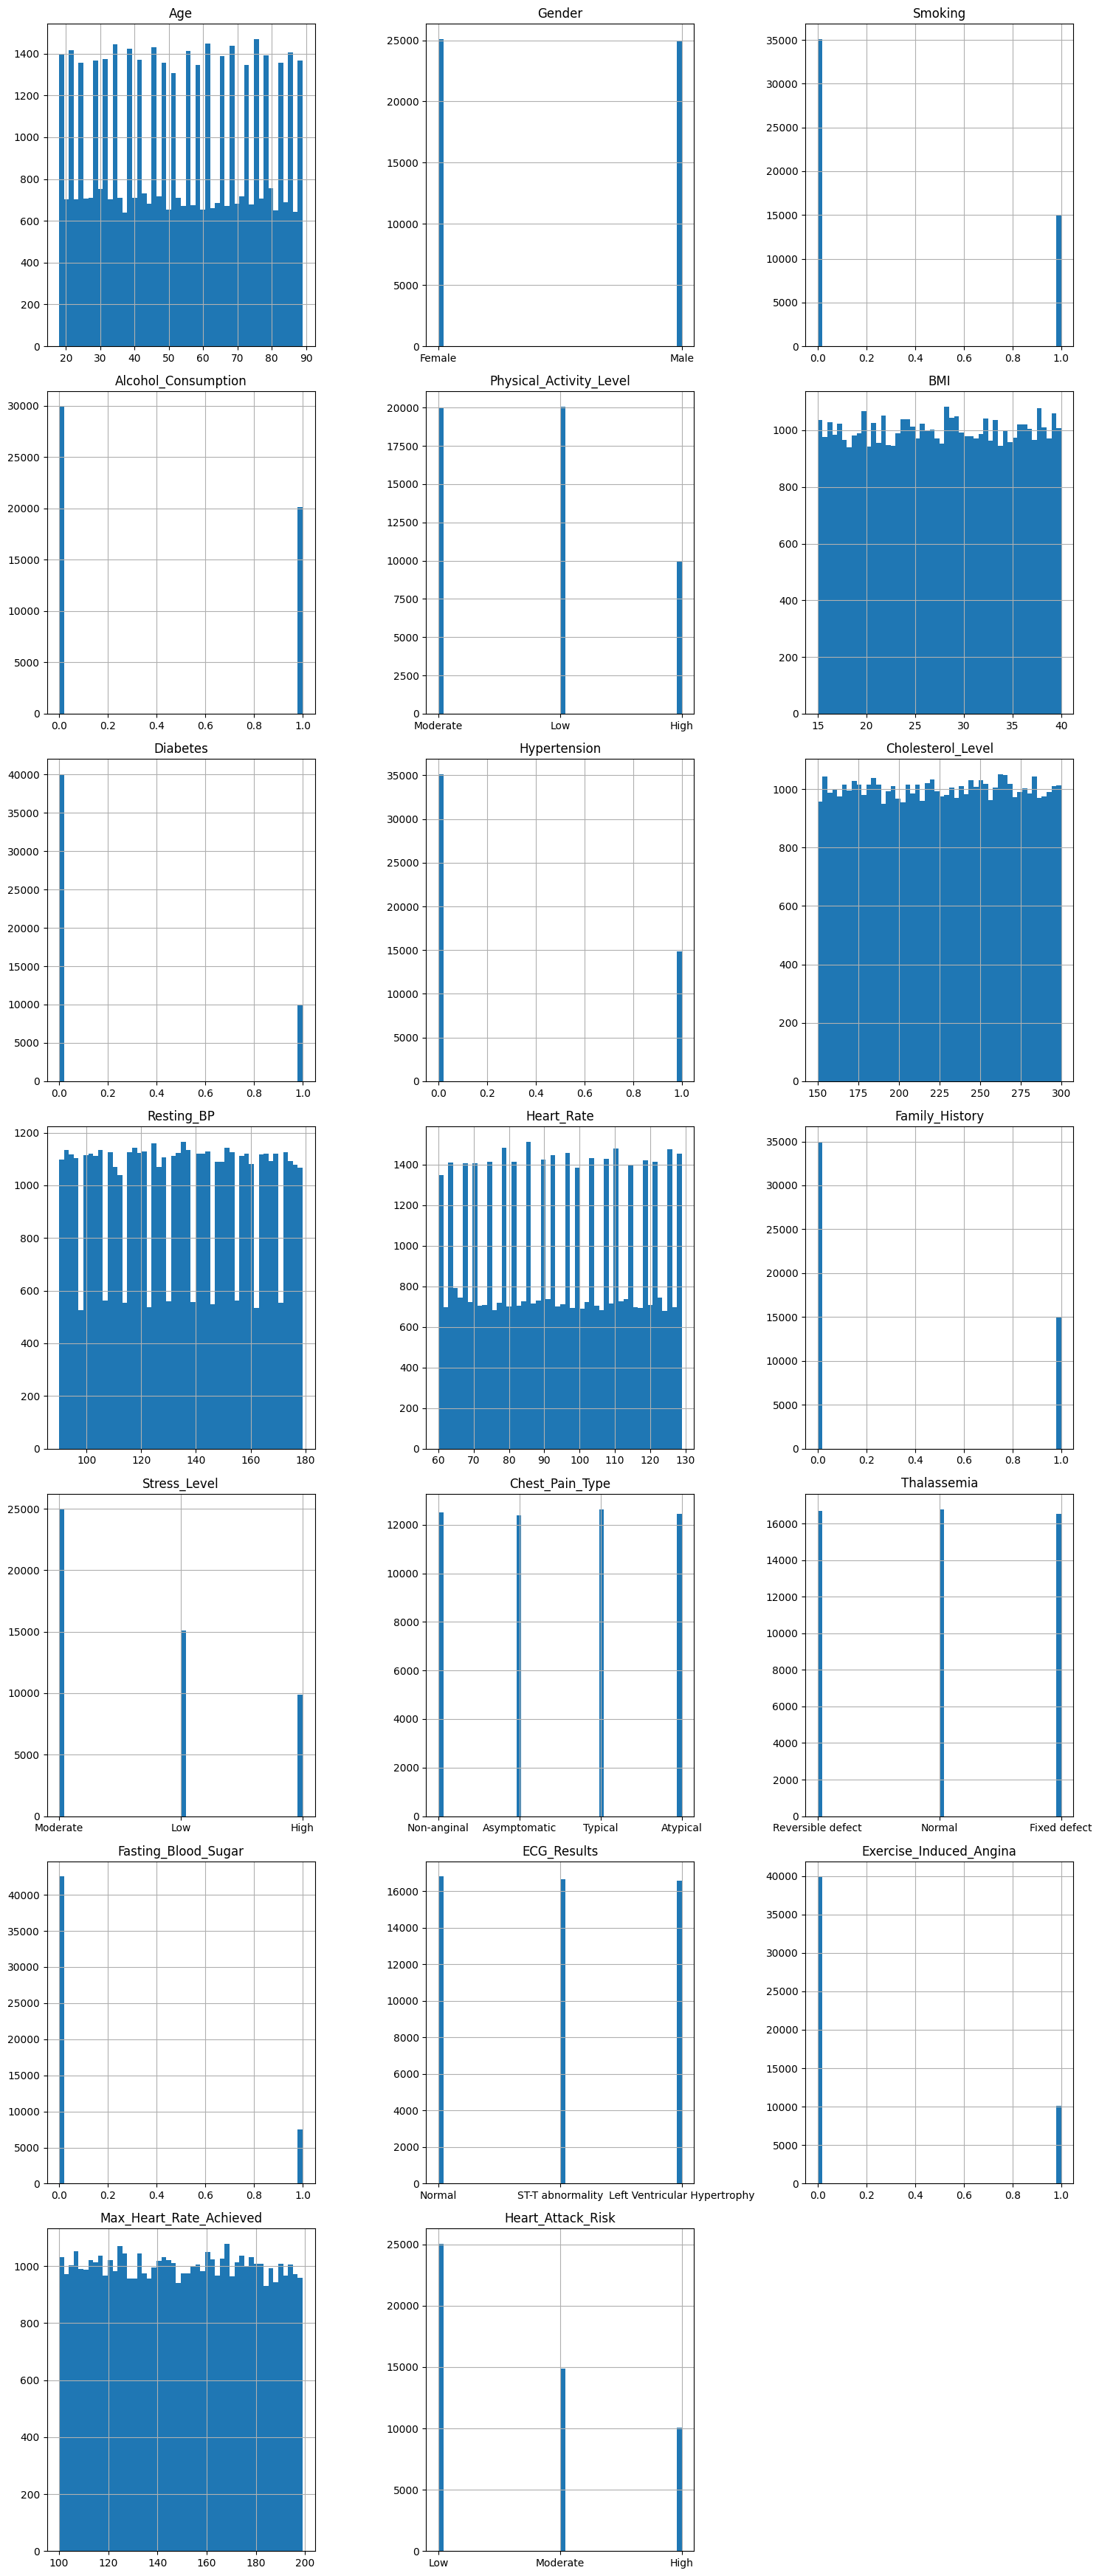

In [7]:
# We nemen eerst een snelle blik op de variabelen via een histogram plot van alle features
# We maken een algemene plot van de variabelen

if plot_graphs:
    num_columns = 3
    num_plots = len(df.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df.columns):
        df[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("algemeen_overzicht_features")
    plt.show()

outlier
-1    46505
 1     3495
Name: count, dtype: int64
93.01


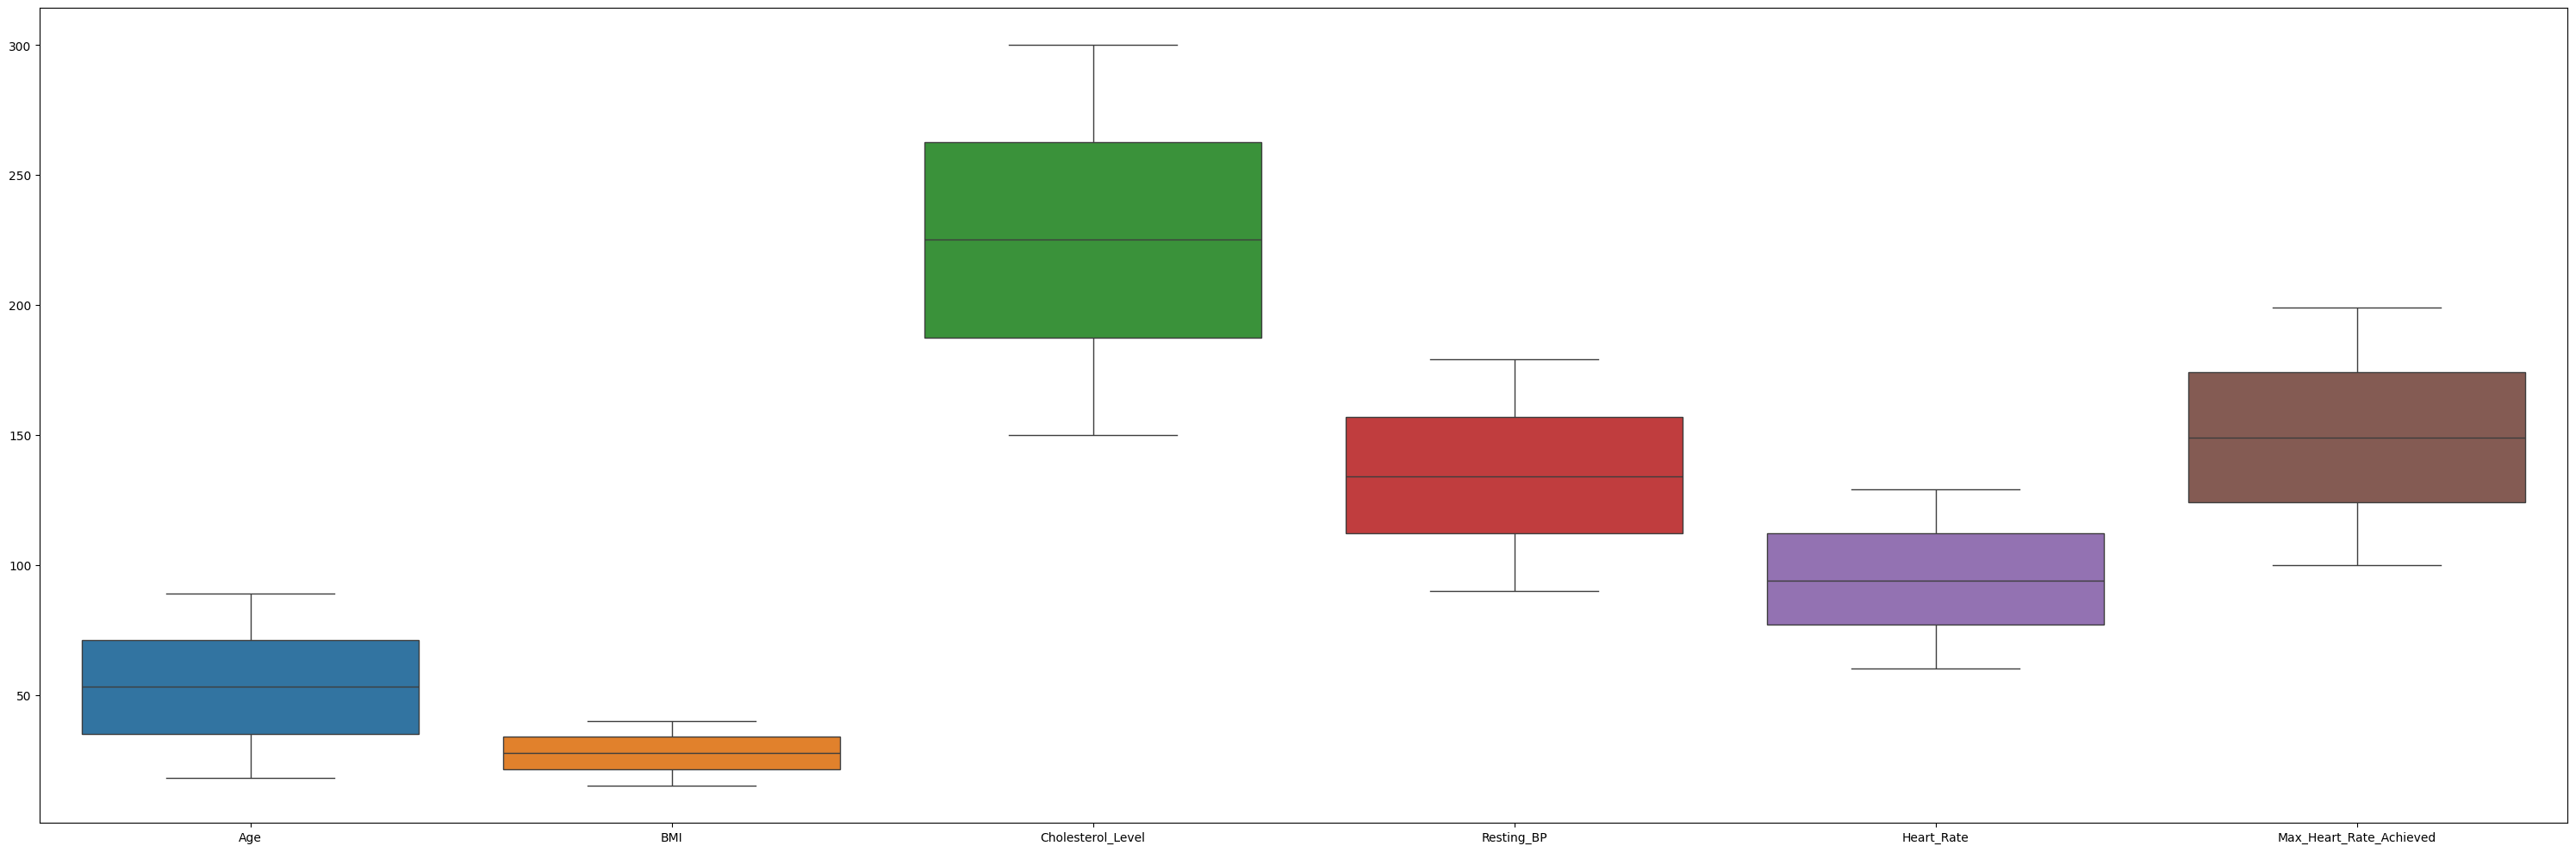

C:\Users\geert\AppData\Local\Temp\ipykernel_24628\506109145.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_24628\506109145.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_24628\506109145.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_24628\506109145.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_24628\506109145.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\

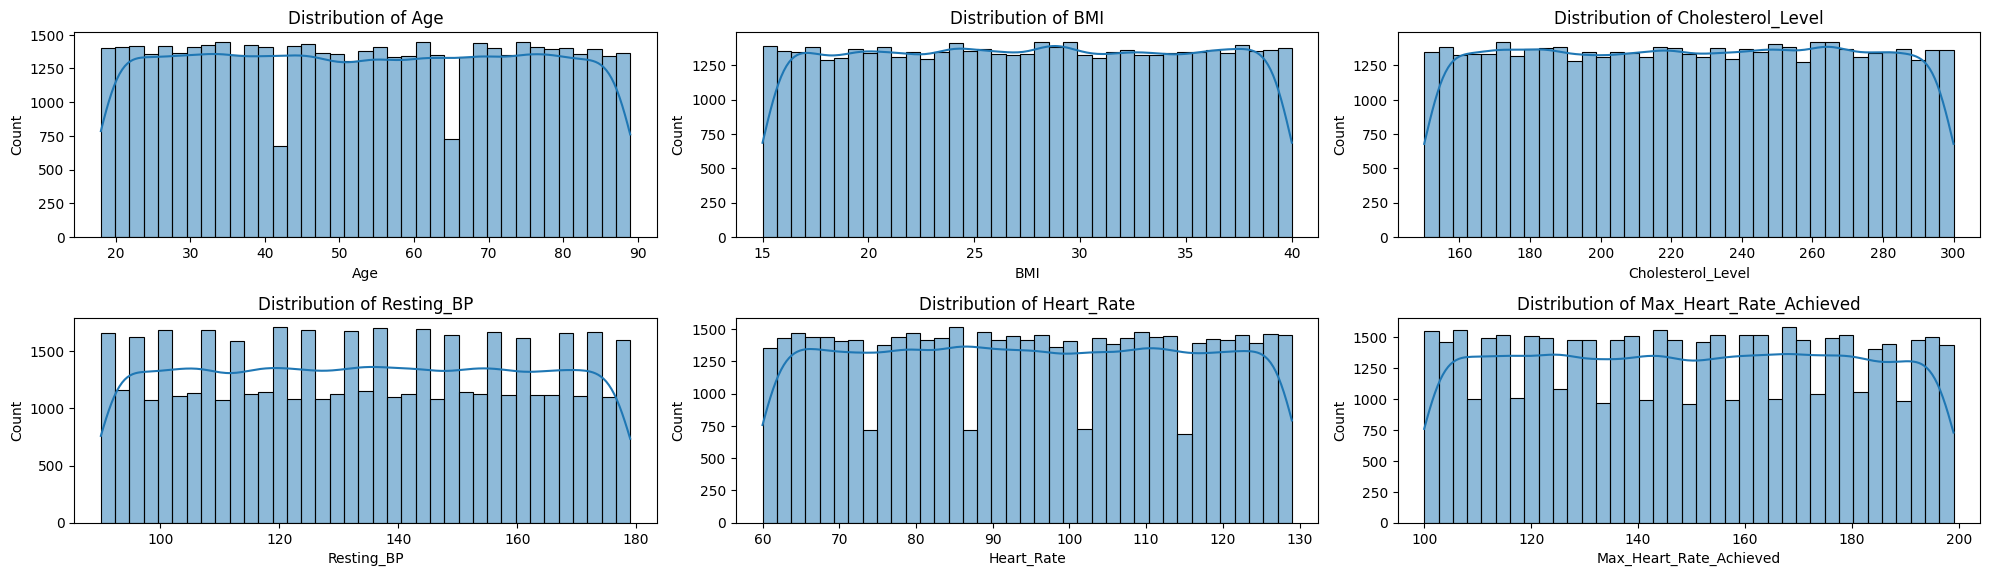

In [8]:
# analyze van de features, eerst de numerische features
# eerst een boxplot, voor de numerische waarde

# outliers berekenen maar hier doen we voorlopig niets mee
aantal_outliers = bereken_percentage_aantal_outliers(df,['Age'])
print(aantal_outliers)

# eerste een box-plot van de numerische variabelen
if plot_graphs:
    fig = plt.figure(figsize=(30,10))
    sns.boxplot(df_num)
    save_fig("Numerische features boxplot van de features")
    plt.show()
# Dit lijkt een normale verdeling. Er is hier geen log-verfijning nodig
# Er zijn ook geen outliers

# We maken nog een apart histogram van de numerische variabelen
plt.figure(figsize=(20,14))
for i, col in enumerate(df_num_col,1):
    plt.subplot(5,3,i)
    sns.histplot(df[col], kde=True, palette='skyblue')
    plt.title(f"Distribution of {col}")
if plot_graphs:
    plt.tight_layout()
    save_fig("Numerische features histogram van de features")
    plt.show()
# Alles lijkt ook hier normaal



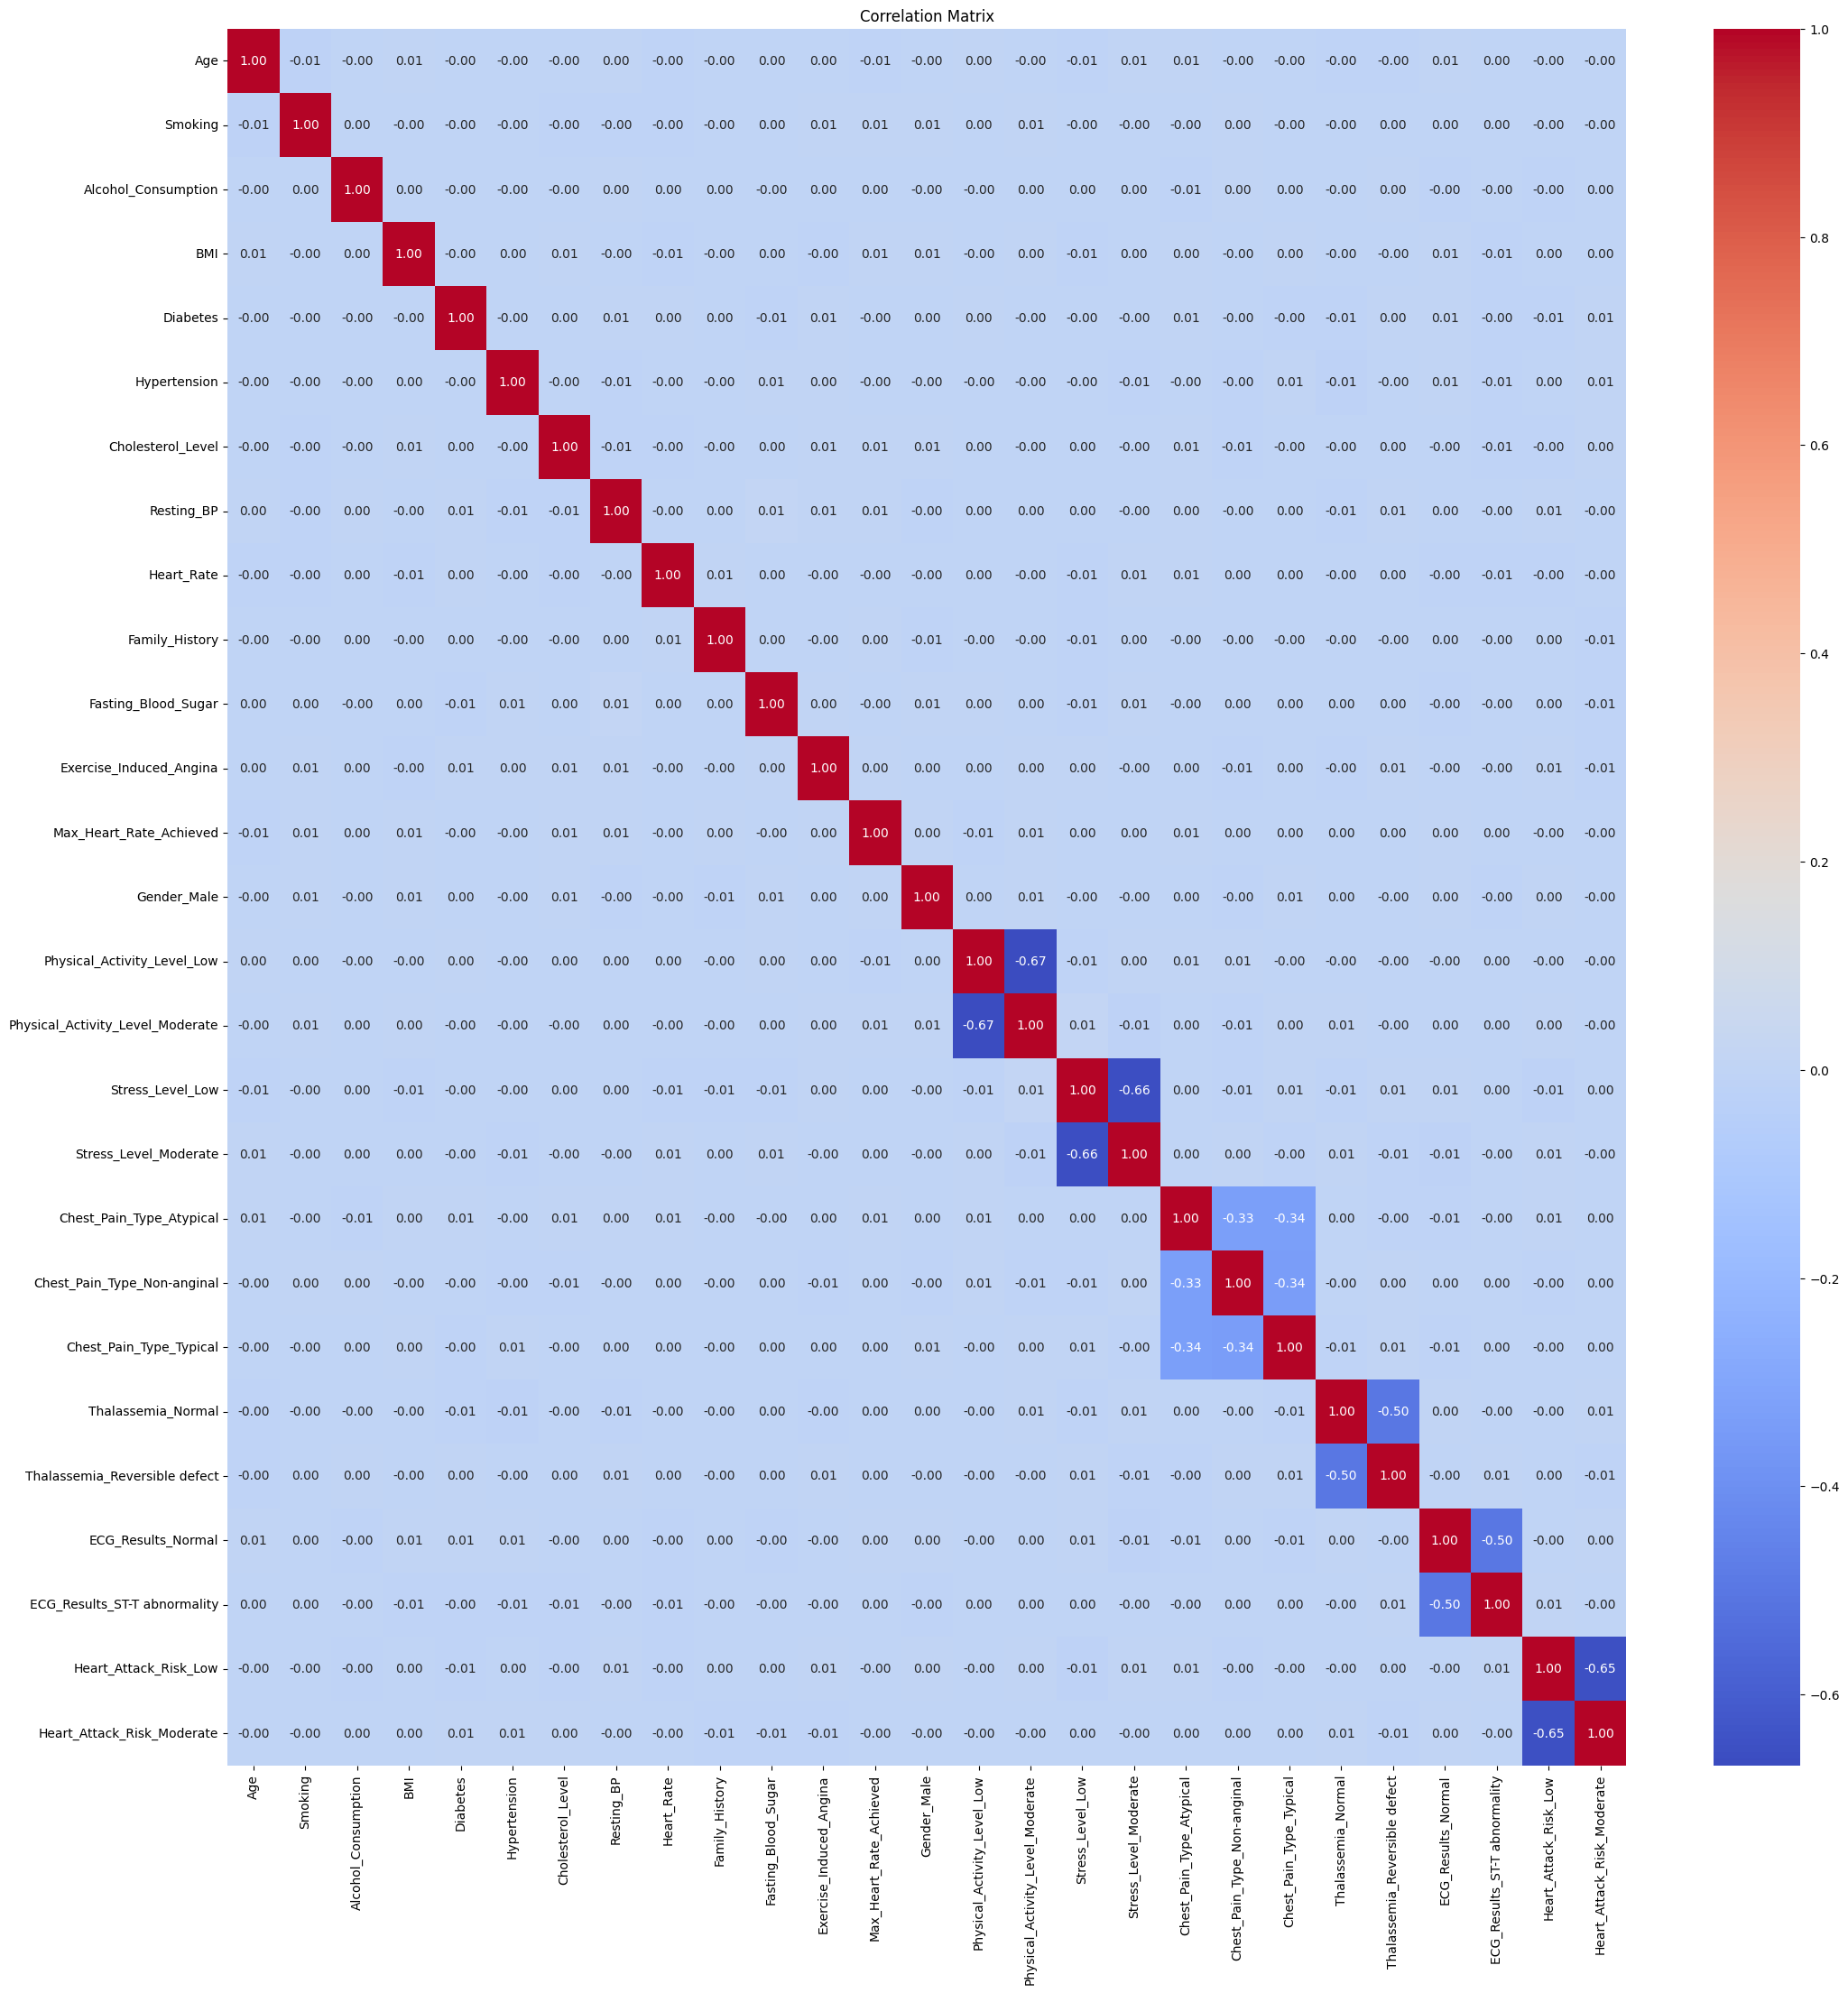

In [9]:
# check correlatie tussen de diverse features

data_num = pd.get_dummies(df, columns=['Gender','Physical_Activity_Level', 'Stress_Level','Chest_Pain_Type', 'Thalassemia', 'ECG_Results', 'Heart_Attack_Risk'], drop_first=True)

plt.figure(figsize=(25,25))
sns.heatmap(data_num.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# weinig correlatie tussen de features
# we kunnen de features dus behouden

In [10]:
# analyze van de categorische features

print(df_cat.head())
print(df_cat.describe())

                    ECG_Results  Hypertension  Gender  Diabetes  \
0                        Normal             0  Female         1   
1              ST-T abnormality             0    Male         0   
2              ST-T abnormality             0    Male         0   
3  Left Ventricular Hypertrophy             0    Male         1   
4              ST-T abnormality             0  Female         0   

  Chest_Pain_Type Physical_Activity_Level  Smoking Heart_Attack_Risk  \
0     Non-anginal                Moderate        1               Low   
1    Asymptomatic                Moderate        0          Moderate   
2         Typical                Moderate        0               Low   
3         Typical                Moderate        0               Low   
4    Asymptomatic                Moderate        1          Moderate   

   Fasting_Blood_Sugar Stress_Level        Thalassemia  Alcohol_Consumption  \
0                    0     Moderate  Reversible defect                    0   
1     

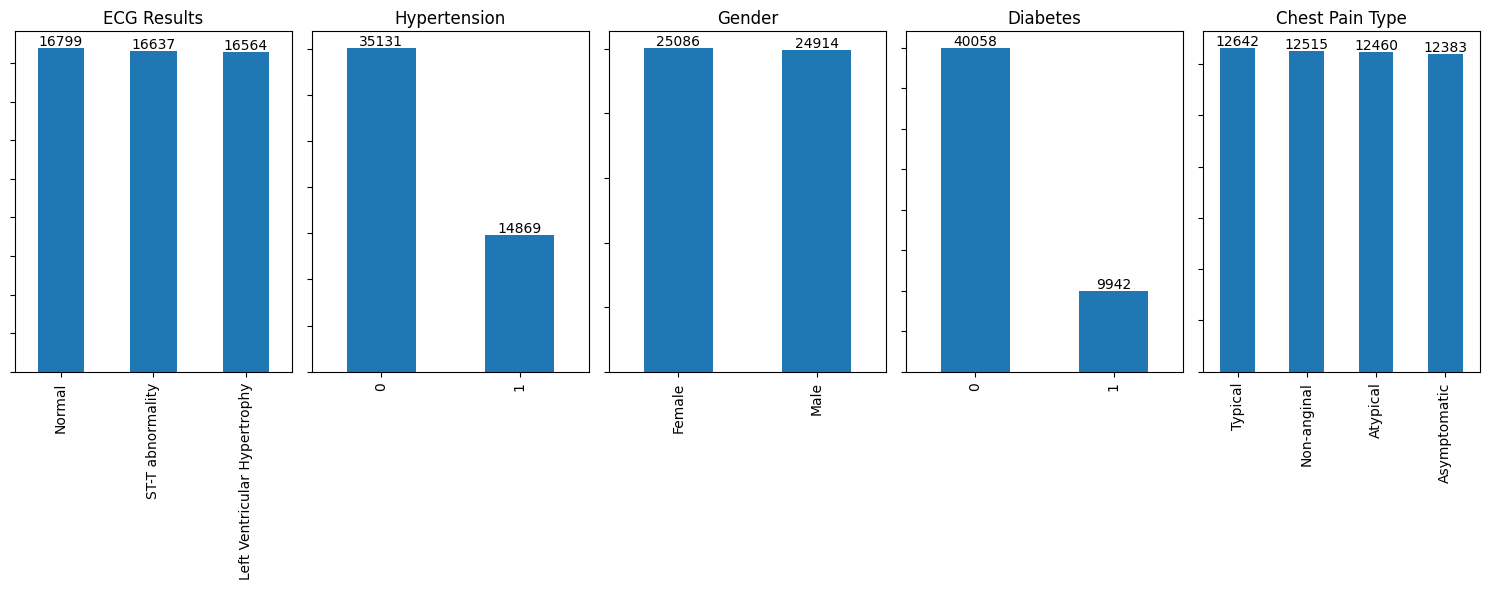

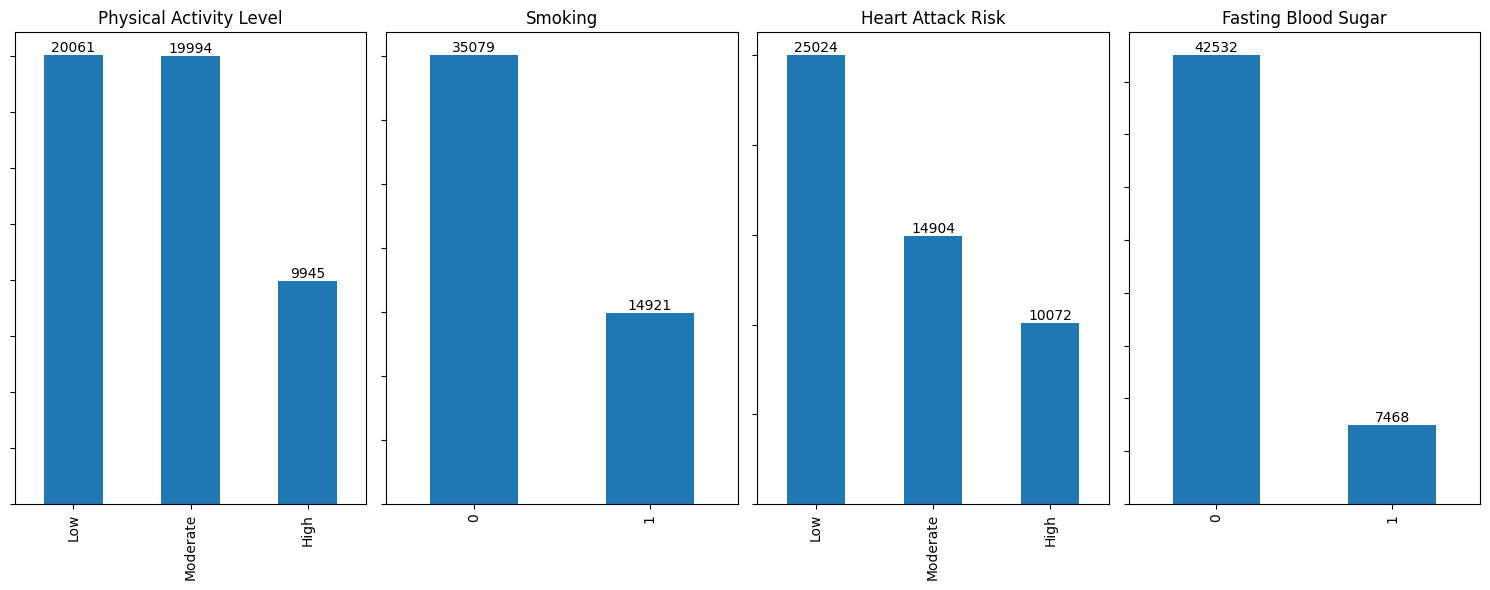

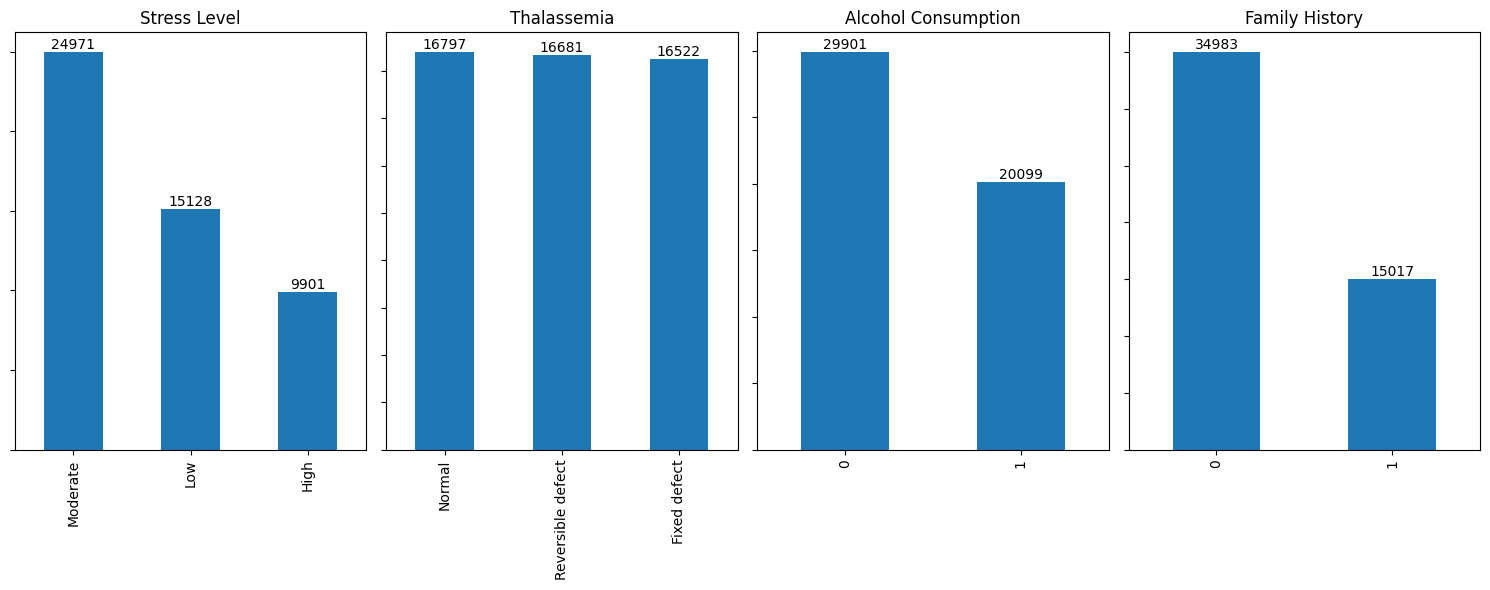

In [11]:
# maak per categorsiche variabel een bar_plot van de voorkomens van de waarden

def bar_labels(axes, rotation= 0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

# plot de categorische waarde af met het voorkomen van de waarde in de dataset
# 14 plots, opgedeeld in 2 rijen met 7 plots

if plot_graphs:
    index = 0
    for r in [5,4,4]:
        fig, axes = plt.subplots(ncols=r, figsize=(15, 6))
        for i in range(r):
            df[df_cat_col[index]].value_counts().plot(kind="bar", ax=axes[i])
            bar_labels(axes[i])
            axes[i].set_title(df_cat_col[index].replace('_', ' '))            
            index+=1      
        plt.tight_layout()   
        save_fig(f"Categorische features value count van de feature deel{r}")
        plt.show()


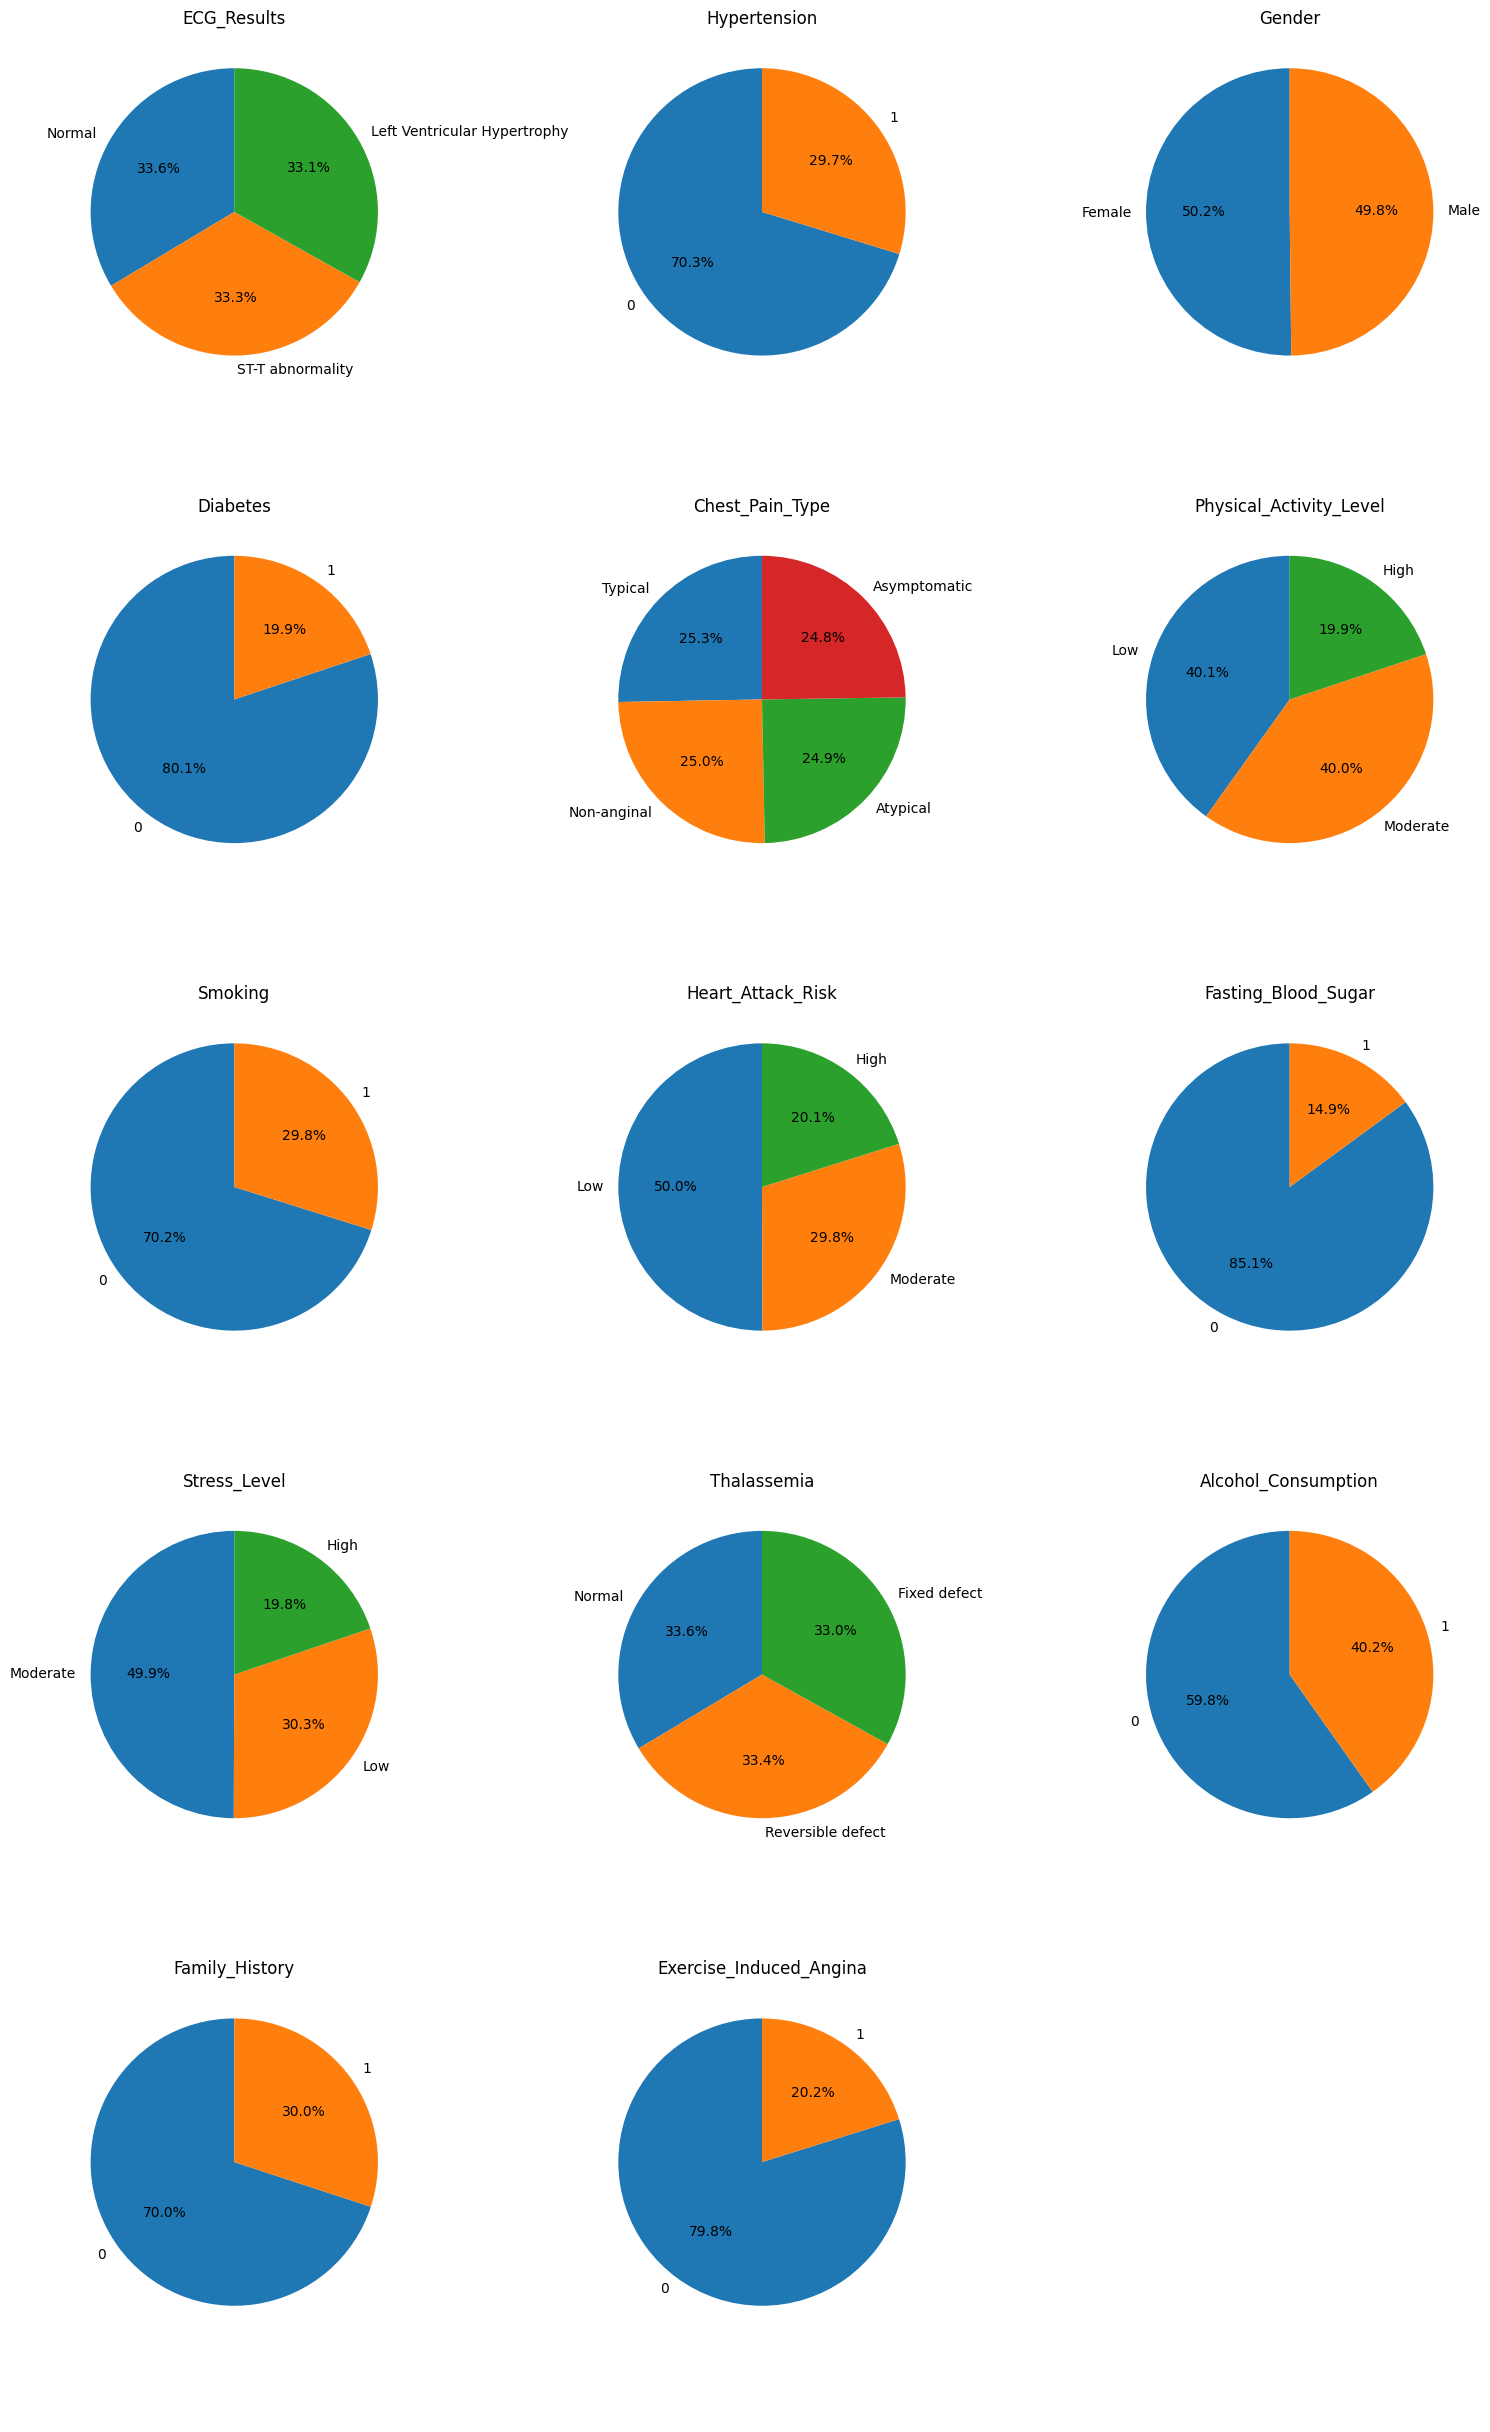

In [12]:
# visuele voorstellen van de unbalance van de categorische variabelen
# Creëer een figuur en een set van subplots
num_columns = 3
num_plots = len(df_cat.columns)
num_rows = (num_plots + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten het axes object voor eenvoudiger iteratie
axes = axes.flatten()

# Loop over alle kolommen en creëer een pie chart voor elke kolom
for i, column in enumerate(df_cat.columns):
    # Haal de waarde tellingen op voor de huidige kolom
    counts = df_cat[column].value_counts()
    
    # Maak een pie chart op de i-th positie in axes
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(column)
    axes[i].set_ylabel('')  # Verwijder de y-label voor netheid

# Verberg eventuele extra subplots als het aantal kolommen minder is dan het aantal subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Toon de plot
plt.tight_layout()
save_fig(f"Categorische features unbalance view")
plt.show()



In [13]:
# SMOTE toepassen
# er is mogelijk wat unbalance in de dataset
# we gaan dit later mee in de pipelining integreren om te kijken wat het effect van SMOTE kan zijn
# testje toegevoegd op random dataset


# Voorbeeld dataset genereren
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

# Data in een DataFrame plaatsen voor visualisatie
df_smote = pd.DataFrame(X)
df_smote['target'] = y

# Toon de klasse distributie voor SMOTE
print('Originele dataset shape %s' % Counter(y))

# Pas SMOTE toe
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Toon de nieuwe klasse distributie
print('Resampled dataset shape %s' % Counter(y_res))

from imblearn.under_sampling import RandomUnderSampler

# Toon de originele klasse distributie
print('Originele dataset shape %s' % Counter(y))

# Configureer de RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = rus.fit_resample(X, y)

# Toon de nieuwe klasse distributie
print('Dataset shape na undersampling %s' % Counter(y_res_under))


Originele dataset shape Counter({np.int64(1): 900, np.int64(0): 100})
Resampled dataset shape Counter({np.int64(0): 900, np.int64(1): 900})
Originele dataset shape Counter({np.int64(1): 900, np.int64(0): 100})
Dataset shape na undersampling Counter({np.int64(0): 100, np.int64(1): 100})


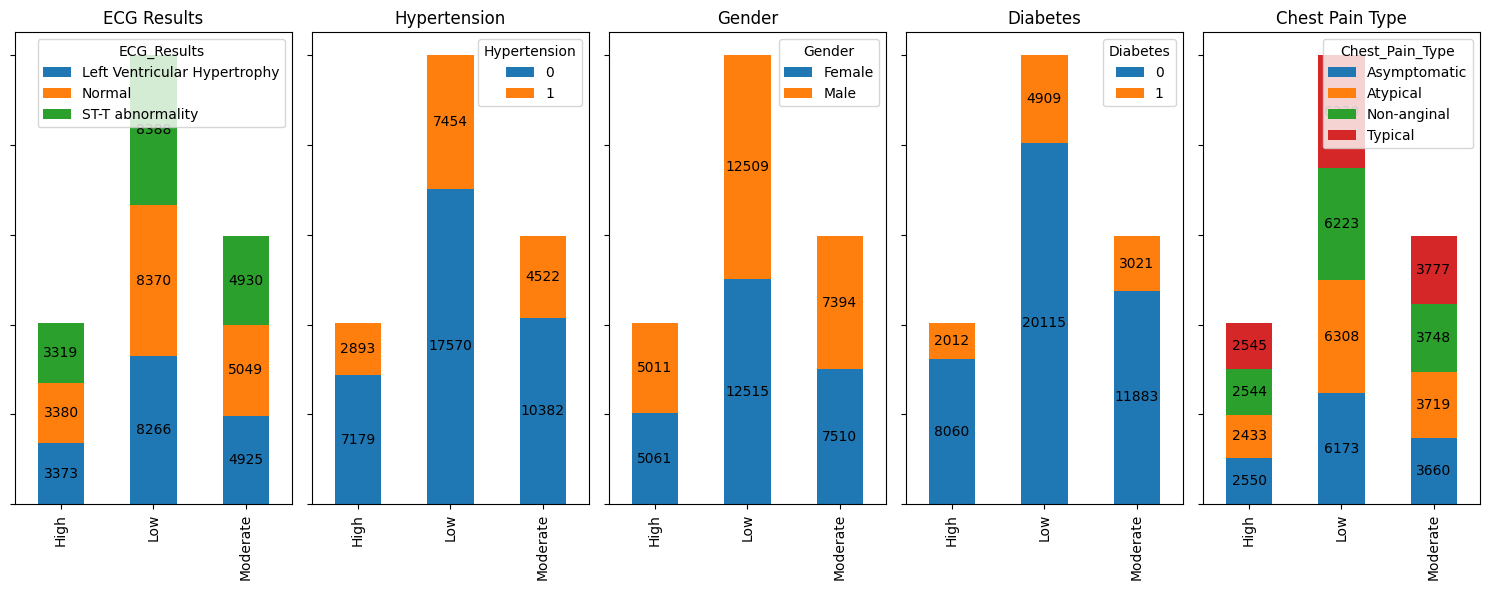

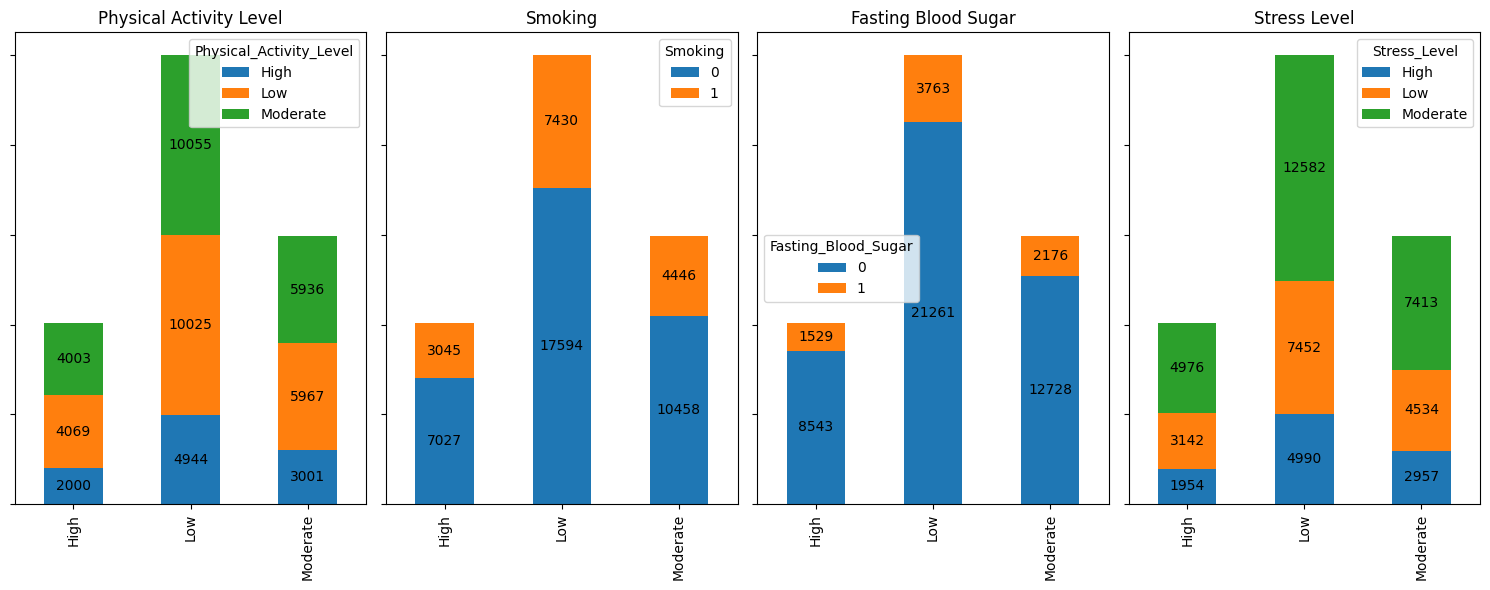

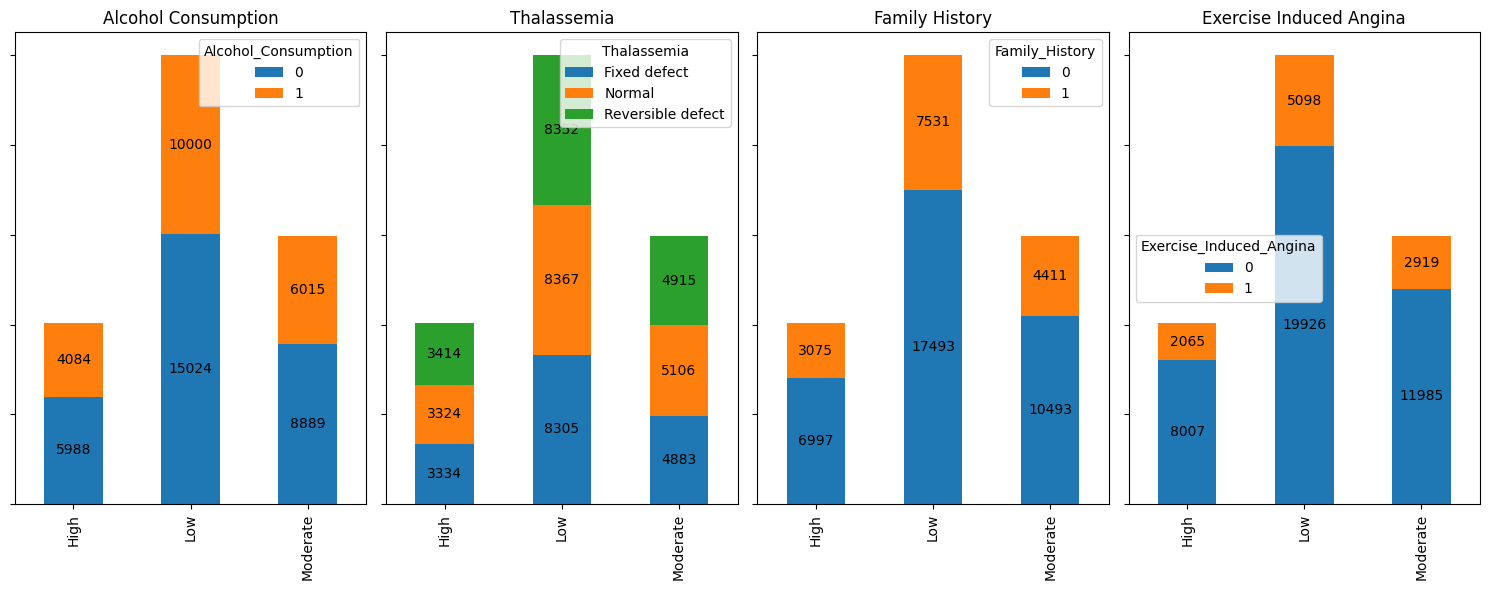

In [14]:
# en nu gaan we op basis van de target value ("Heart risk") groeperen en kijken wat de impact is van de diverse
# categorische variabelen

index = 0
grouped = df.groupby(df_label_col)
df_group_cols = list(set(df_cat_col) - set(df_label_col))
# plot 13 grafieken, 
if plot_graphs:
    for j in [5, 4, 4]:
        fig, axes = plt.subplots(ncols=j, figsize=(15, 6))
        for i in range(j):
            grouped[df_group_cols[index]].value_counts().unstack().plot(kind="bar", stacked=True, ax=axes[i])
            bar_labels(axes[i], 0, "center")
            axes[i].set_title(df_group_cols[index].replace('_', ' '))
            index+=1
        plt.tight_layout()
        save_fig(f"Categorische features per value van de target value deel {r}")
        plt.show()

14/02/2025 11:11:30 : Info : Eenvoudige logistic regression met stratify op de target value
14/02/2025 11:11:30 : Info : **************************************************************


c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


14/02/2025 11:11:30 : Info : Voorkomens in y_pred: Counter({'Low': 10000})
14/02/2025 11:11:30 : Info : Voorkomens in y_test: Counter({'Low': 5005, 'Moderate': 2981, 'High': 2014})
14/02/2025 11:11:31 : Info : 
accuracy_score: 50.05
14/02/2025 11:11:31 : Info : classification_report:               precision    recall  f1-score   support

        High       0.00      0.00      0.00      2014
         Low       0.50      1.00      0.67      5005
    Moderate       0.00      0.00      0.00      2981

    accuracy                           0.50     10000
   macro avg       0.17      0.33      0.22     10000
weighted avg       0.25      0.50      0.33     10000

14/02/2025 11:11:31 : Info : Confusion matrix: +-----+------+-----+
|   0 |    1 |   2 |
|-----+------+-----|
|   0 | 2014 |   0 |
|   0 | 5005 |   0 |
|   0 | 2981 |   0 |
+-----+------+-----+


c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


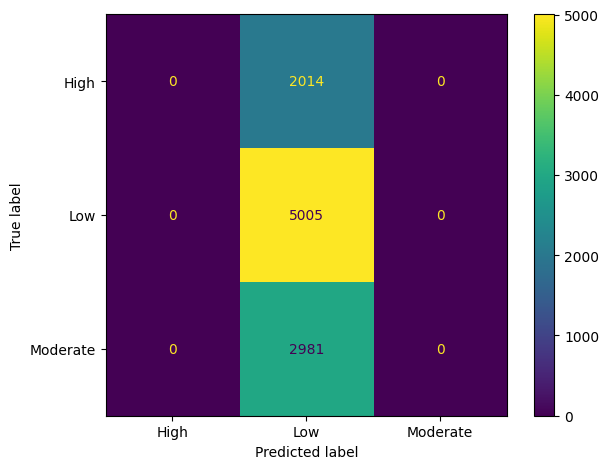

In [15]:
# Eenvoudige Logistic regression met pipeline opzet 
# met stratefy op de target value
# en zonder SMOTE

log_info(f"Eenvoudige logistic regression met stratify op de target value")
log_info("**************************************************************")

df = df_raw.copy()

# Separate features (X) and target variable (y)
X = df.drop(columns=['Heart_Attack_Risk'])
y = df['Heart_Attack_Risk']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define categorical and numerical column names
df_col = X.columns  
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))

num_pipeline = Pipeline([   
    ("standardize_numerical", MinMaxScaler(feature_range=(-1, 1)))
    # ("standardize_numerical", StandardScaler())
])

cat_pipeline = Pipeline(steps=[   
    ('encode_categorical', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ("numerical", num_pipeline, df_num_col),
    ("categorical", cat_pipeline, df_cat_col)],
     remainder='passthrough')

# Create the pipeline with preprocessing and logistic regression
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('SMOTE', SMOTE(random_state=42)),
    # ('regressor', RandomForestClassifier(random_state=42))
    ('regressor', LogisticRegression(solver='lbfgs', multi_class='multinomial', C=1.0, penalty='l2', max_iter=100))
    # ('regressor', LogisticRegression(multi_class="multinomial",max_iter=100))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Making predictions on the test set
y_pred = pipeline.predict(X_test)

y_pred_counter = Counter(y_pred)
y_test_counter = Counter(y_test)
log_info(f"Voorkomens in y_pred: {y_pred_counter}")
log_info(f"Voorkomens in y_test: {y_test_counter}")

acc_score = accuracy_score(y_test,y_pred)*100
class_report = classification_report(y_test,y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

log_info(f"\naccuracy_score: {acc_score}")
log_info(f"classification_report: {class_report}")
summary_conf_matrix = tabulate(conf_matrix, headers='keys', tablefmt='psql')
log_info(f"Confusion matrix: {summary_conf_matrix}")

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()
save_fig("Confusion matrix - example logistic regression zonder SMOTE")


14/02/2025 11:11:31 : Info : Eenvoudige logistic regression met SMOTE en met stratify op de target value
14/02/2025 11:11:31 : Info : ********************************************************************


c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


14/02/2025 11:11:31 : Info : Voorkomens in y_pred: Counter({'High': 3596, 'Low': 3377, 'Moderate': 3027})
14/02/2025 11:11:31 : Info : Voorkomens in y_test: Counter({'Low': 5005, 'Moderate': 2981, 'High': 2014})
14/02/2025 11:11:32 : Info : 
accuracy_score: 33.739999999999995
14/02/2025 11:11:32 : Info : classification_report:               precision    recall  f1-score   support

        High       0.21      0.37      0.26      2014
         Low       0.50      0.34      0.41      5005
    Moderate       0.31      0.31      0.31      2981

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.33     10000
weighted avg       0.39      0.34      0.35     10000

14/02/2025 11:11:32 : Info : Confusion matrix: +------+------+------+
|    0 |    1 |    2 |
|------+------+------|
|  742 |  679 |  593 |
| 1795 | 1704 | 1506 |
| 1059 |  994 |  928 |
+------+------+------+


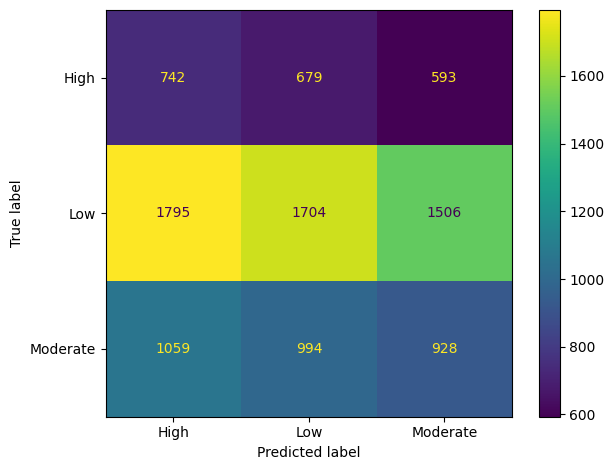

In [16]:
# Eenvoudige Logistic regression met pipeline opzet en met SMOTE
# nu met stratefy op de target value

log_info(f"Eenvoudige logistic regression met SMOTE en met stratify op de target value")
log_info("********************************************************************")

df = df_raw.copy()

# Separate features (X) and target variable (y)
X = df.drop(columns=['Heart_Attack_Risk'])
y = df['Heart_Attack_Risk']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define categorical and numerical column names
df_col = X.columns  
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))

num_pipeline = Pipeline([   
    ("standardize_numerical", MinMaxScaler(feature_range=(-1, 1)))
    # ("standardize_numerical", StandardScaler())
])

cat_pipeline = Pipeline(steps=[   
    ('encode_categorical', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ("numerical", num_pipeline, df_num_col),
    ("categorical", cat_pipeline, df_cat_col)],
     remainder='passthrough')

# Create the pipeline with preprocessing and logistic regression
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),
    # ('regressor', RandomForestClassifier(random_state=42))
    ('regressor', LogisticRegression(solver='lbfgs', multi_class='multinomial', C=1.0, penalty='l2', max_iter=100))
    # ('regressor', LogisticRegression(multi_class="multinomial",max_iter=100))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Making predictions on the test set
y_pred = pipeline.predict(X_test)

y_pred_counter = Counter(y_pred)
y_test_counter = Counter(y_test)
log_info(f"Voorkomens in y_pred: {y_pred_counter}")
log_info(f"Voorkomens in y_test: {y_test_counter}")

acc_score = accuracy_score(y_test, y_pred)*100
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

log_info(f"\naccuracy_score: {acc_score}")
log_info(f"classification_report: {class_report}")
summary_conf_matrix = tabulate(conf_matrix, headers='keys', tablefmt='psql')
log_info(f"Confusion matrix: {summary_conf_matrix}")

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()
save_fig("Confusion matrix - example logistic regression met SMOTE")



14/02/2025 11:11:38 : Info : 

Model : Random Forest
14/02/2025 11:11:38 : Info : Confusion matrix: [[   9 1903  102]
 [  12 4777  216]
 [   3 2835  143]]
14/02/2025 11:11:38 : Info : Classification report:               precision    recall  f1-score   support

        High       0.38      0.00      0.01      2014
         Low       0.50      0.95      0.66      5005
    Moderate       0.31      0.05      0.08      2981

    accuracy                           0.49     10000
   macro avg       0.40      0.34      0.25     10000
weighted avg       0.42      0.49      0.36     10000

14/02/2025 11:11:38 : Info : Accuracy scores: 0.4929


c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metric

14/02/2025 11:11:41 : Info : 

Model : Ada Boost
14/02/2025 11:11:41 : Info : Confusion matrix: [[   0 2013    1]
 [   0 5002    3]
 [   0 2974    7]]
14/02/2025 11:11:41 : Info : Classification report:               precision    recall  f1-score   support

        High       0.00      0.00      0.00      2014
         Low       0.50      1.00      0.67      5005
    Moderate       0.64      0.00      0.00      2981

    accuracy                           0.50     10000
   macro avg       0.38      0.33      0.22     10000
weighted avg       0.44      0.50      0.34     10000

14/02/2025 11:11:41 : Info : Accuracy scores: 0.5009


c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


14/02/2025 11:11:55 : Info : 

Model : Gradient Boosting
14/02/2025 11:11:55 : Info : Confusion matrix: [[   1 2003   10]
 [   2 4986   17]
 [   1 2969   11]]
14/02/2025 11:11:55 : Info : Classification report:               precision    recall  f1-score   support

        High       0.25      0.00      0.00      2014
         Low       0.50      1.00      0.67      5005
    Moderate       0.29      0.00      0.01      2981

    accuracy                           0.50     10000
   macro avg       0.35      0.33      0.22     10000
weighted avg       0.39      0.50      0.34     10000

14/02/2025 11:11:55 : Info : Accuracy scores: 0.4998
14/02/2025 11:12:00 : Info : 

Model : Extra Trees
14/02/2025 11:12:00 : Info : Confusion matrix: [[  39 1789  186]
 [  91 4360  554]
 [  69 2599  313]]
14/02/2025 11:12:00 : Info : Classification report:               precision    recall  f1-score   support

        High       0.20      0.02      0.04      2014
         Low       0.50      0.87      0.

c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cas

14/02/2025 11:12:00 : Info : 

Model : Logistic Regression
14/02/2025 11:12:00 : Info : Confusion matrix: [[   0 2014    0]
 [   0 5005    0]
 [   0 2981    0]]
14/02/2025 11:12:00 : Info : Classification report:               precision    recall  f1-score   support

        High       0.00      0.00      0.00      2014
         Low       0.50      1.00      0.67      5005
    Moderate       0.00      0.00      0.00      2981

    accuracy                           0.50     10000
   macro avg       0.17      0.33      0.22     10000
weighted avg       0.25      0.50      0.33     10000

14/02/2025 11:12:00 : Info : Accuracy scores: 0.5005


c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

14/02/2025 11:14:42 : Info : 

Model : Support Vector Machine
14/02/2025 11:14:42 : Info : Confusion matrix: [[   0 2014    0]
 [   0 5005    0]
 [   0 2981    0]]
14/02/2025 11:14:43 : Info : Classification report:               precision    recall  f1-score   support

        High       0.00      0.00      0.00      2014
         Low       0.50      1.00      0.67      5005
    Moderate       0.00      0.00      0.00      2981

    accuracy                           0.50     10000
   macro avg       0.17      0.33      0.22     10000
weighted avg       0.25      0.50      0.33     10000

14/02/2025 11:14:43 : Info : Accuracy scores: 0.5005


c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


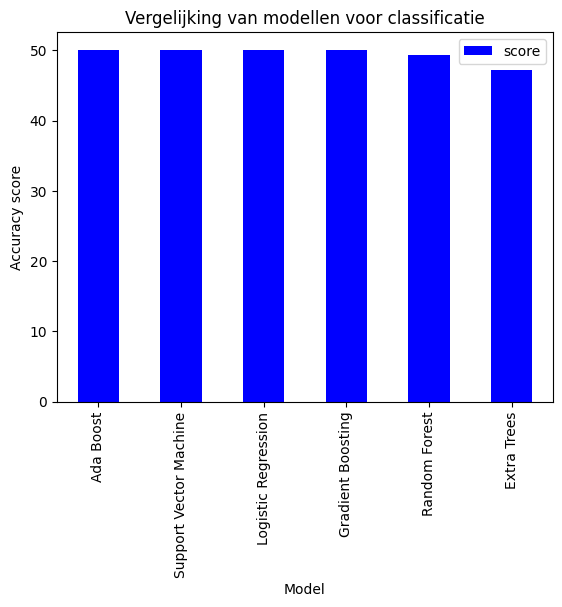

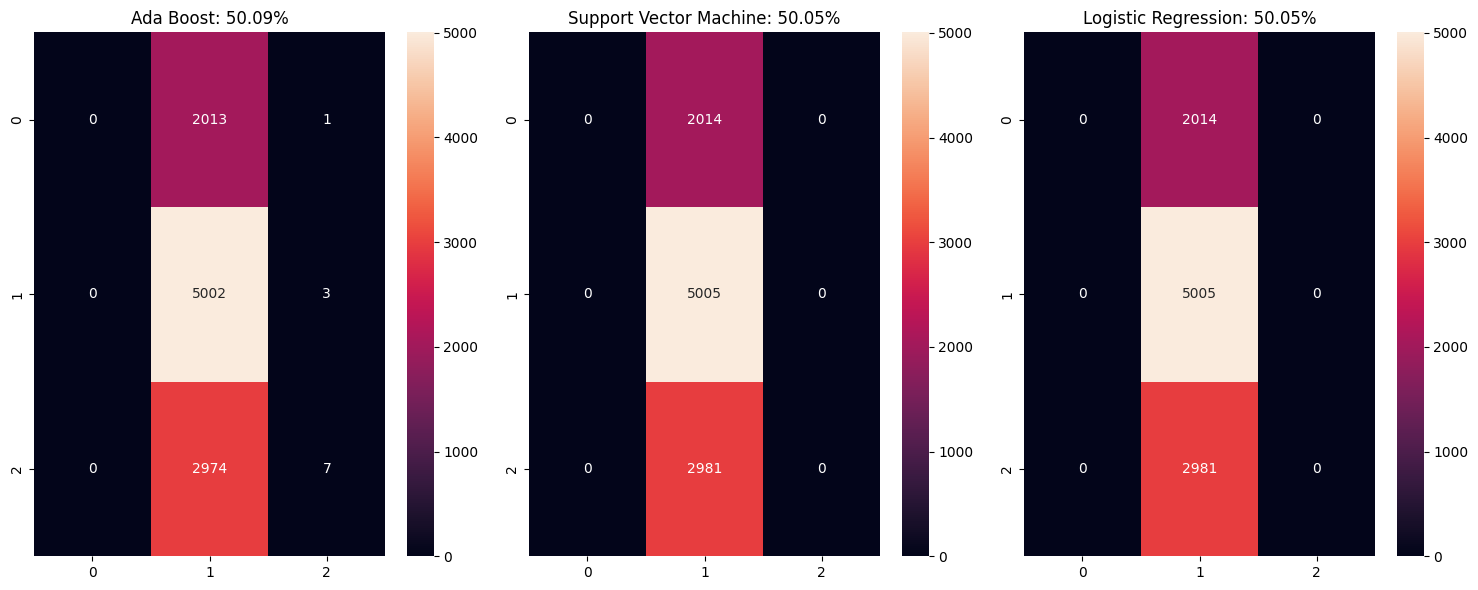

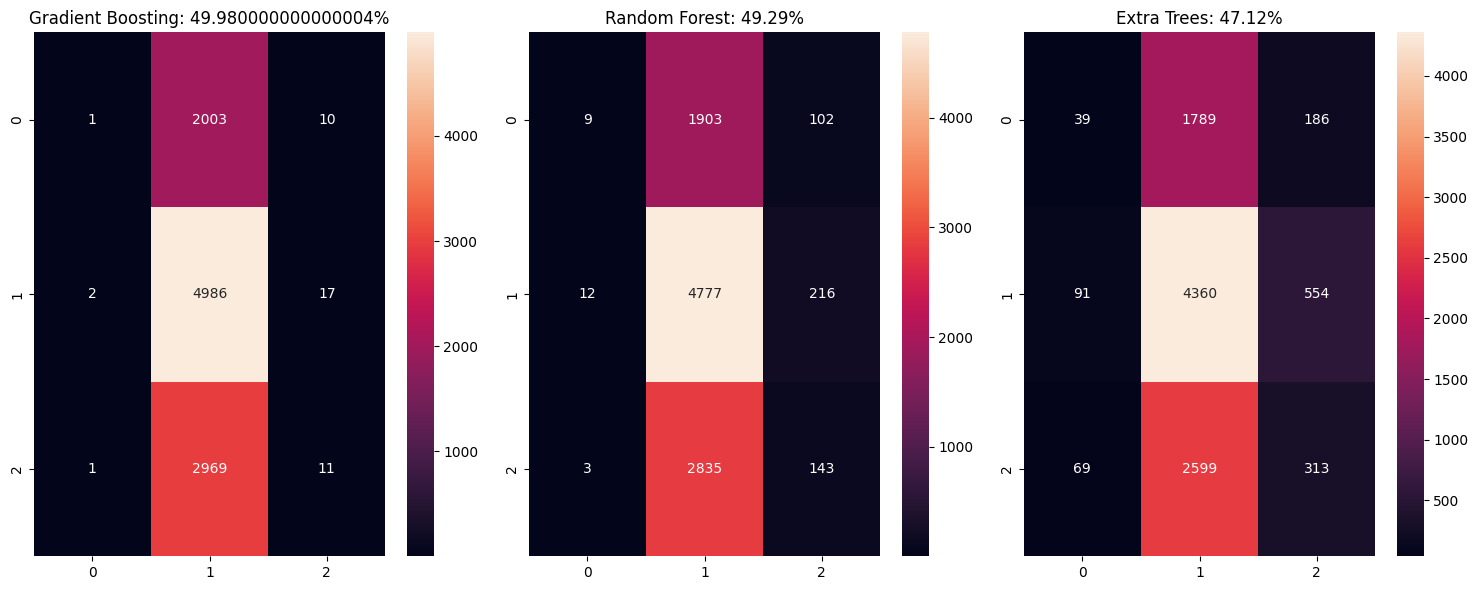

******************************
Random Forest
              precision    recall  f1-score   support

        High       0.38      0.00      0.01      2014
         Low       0.50      0.95      0.66      5005
    Moderate       0.31      0.05      0.08      2981

    accuracy                           0.49     10000
   macro avg       0.40      0.34      0.25     10000
weighted avg       0.42      0.49      0.36     10000

14/02/2025 11:14:43 : Info : 

Resultaten model Random Forest
14/02/2025 11:14:43 : Info : 

Resultaten 50.09
14/02/2025 11:14:43 : Info :               precision    recall  f1-score   support

        High       0.38      0.00      0.01      2014
         Low       0.50      0.95      0.66      5005
    Moderate       0.31      0.05      0.08      2981

    accuracy                           0.49     10000
   macro avg       0.40      0.34      0.25     10000
weighted avg       0.42      0.49      0.36     10000




******************************
Ada Boost
          

In [17]:
# en nu gaan we voor een aantal classificatie modellen dit uitvoeren
# en checken wat het beste model is tot nu toe
# zonder SMOTE omdat we merken dat SMOTE niet bijdraagt aan een betere score

# duurt enkele minuten !!!

# het beste model is Random Forest maar weinig verschil met de andere modellen

rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
etc = ExtraTreesClassifier()
svc = SVC()
lgr = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=1.0, penalty='l2', max_iter=100)

models_cl = [rfc, abc, gbc, etc, lgr, svc]

names_cl = ["Random Forest", "Ada Boost", "Gradient Boosting", "Extra Trees", "Logistic Regression", "Support Vector Machine"]


def training_classification():
    scores, reports, cms = [], dict(), dict()
    for i, j in zip(models_cl, names_cl):
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            # ('SMOTE', SMOTE(random_state=42)),           
            ('regressor', i)            
            ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        scores += [accuracy_score(y_test, y_pred)*100]
        reports[j] = classification_report(y_test, y_pred)
        cms[j] = confusion_matrix(y_test,y_pred)
        log_info(f"\n\nModel : {j}")
        log_info(f"Confusion matrix: {confusion_matrix(y_test, y_pred)}") 
        log_info(f"Classification report: {classification_report(y_test, y_pred)}")
        log_info(f"Accuracy scores: {accuracy_score(y_test, y_pred)}")


    fig, axes = plt.subplots()
    df_results = pd.DataFrame({"score": scores}, index=names_cl)
    df_results = df_results.sort_values("score", ascending=False)

    # plot de scores    
    df_results.plot(kind="bar", ax=axes, color="blue")  

    # Labels en titel toevoegen
    plt.xlabel('Model')  # Label voor de x-as
    plt.ylabel('Accuracy score')  # Label voor de y-as
    plt.title('Vergelijking van modellen voor classificatie')  # Titel van de plot

    # De plot tonen
    plt.show()

    index = 0
    for _ in range(2):
        fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
        for i in range(3):
            sns.heatmap(cms[df_results.index[index]], annot=True, fmt='d', ax=axes[i])
            axes[i].set_title("{}: {}%".format(df_results.index[index], df_results.iloc[index, 0]))
            index += 1
        plt.tight_layout()
        plt.show()

    index = 0
    for i in names_cl:
        print("*"*30)
        print(i)
        print(reports[i]) 
        log_info(f"\n\nResultaten model {names_cl[index]}")
        log_info(f"\n\nResultaten {df_results.iloc[index, 0]}")
        log_info(f"{reports[i]}")
        print("\n\n")
        index += 1

training_classification()





In [18]:
# GridSearchCV voor de beste parameters voor Random Forrest


# Definieer de pipeline met preprocessing en het model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Voer eerst de preprocessing uit
    ('classifier', RandomForestClassifier(random_state=42))  # Dan het model
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [4, 5, 6, 7, 8],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(model_pipeline, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Beste parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Voorspellingen doen met het beste model
y_pred = best_model.predict(X_test)
# Evalueer de voorspellingen
print(classification_report(y_test, y_pred))



log_info("\nGridSearchCV voor de beste parameters voor Random Forrest")
log_info("**************************************************************\n")
log_info(f"Accuracy scores: {accuracy_score(y_test, y_pred)}")
log_info(f"\n\nBeste parameters: {grid_search.best_params_}")
log_info(f"Beste model: {best_model}")
log_info(f"Classification report: {classification_report(y_test, y_pred)}")


Fitting 3 folds for each of 60 candidates, totalling 180 fits


c:\data\repos\data_science_cases\myenv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Beste parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__max_features': 'log2', 'classifier__n_estimators': 100}


c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

        High       0.00      0.00      0.00      2014
         Low       0.50      1.00      0.67      5005
    Moderate       0.00      0.00      0.00      2981

    accuracy                           0.50     10000
   macro avg       0.17      0.33      0.22     10000
weighted avg       0.25      0.50      0.33     10000

14/02/2025 11:15:45 : Info : 
GridSearchCV voor de beste parameters voor Random Forrest
14/02/2025 11:15:45 : Info : **************************************************************

14/02/2025 11:15:45 : Info : Accuracy scores: 0.5005
14/02/2025 11:15:45 : Info : 

Beste parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__max_features': 'log2', 'classifier__n_estimators': 100}
14/02/2025 11:15:45 : Info : Beste model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
       

c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# GridSearchCV voor de beste parameters voor Decision Tree


# Definieer de pipeline met preprocessing en het model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Voer eerst de preprocessing uit
    ('classifier', DecisionTreeClassifier(random_state=42))  # Dan het model
])


param_grid = {
    'classifier__max_depth': [None, 5, 6],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__min_samples_split': [2, 3]
}


grid_search = GridSearchCV(model_pipeline, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Beste parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Voorspellingen doen met het beste model
y_pred = best_model.predict(X_test)
# Evalueer de voorspellingen
print(classification_report(y_test, y_pred))


log_info("\nGridSearchCV voor de beste parameters voor Decision Tree")
log_info("**************************************************************\n")
log_info(f"Accuracy scores: {accuracy_score(y_test, y_pred)}")
log_info(f"\n\nBeste parameters: {grid_search.best_params_}")
log_info(f"Beste model: {best_model}")
log_info(f"Classification report: {classification_report(y_test, y_pred)}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Beste parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

        High       0.00      0.00      0.00      2014
         Low       0.50      1.00      0.67      5005
    Moderate       0.37      0.00      0.01      2981

    accuracy                           0.50     10000
   macro avg       0.29      0.33      0.23     10000
weighted avg       0.36      0.50      0.34     10000

14/02/2025 11:15:57 : Info : 
GridSearchCV voor de beste parameters voor Decision Tree
14/02/2025 11:15:57 : Info : **************************************************************

14/02/2025 11:15:57 : Info : Accuracy scores: 0.5004
14/02/2025 11:15:57 : Info : 

Beste parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
14/02/2025 11:15:57 : Info : Beste model: Pipeline(steps=[